Detect spontaneous synaptic transmission and parameters.

In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pdb
from Patch_ana import patch_pip, spon_ana
import seaborn as sns
import pickle
from matplotlib.backends.backend_pdf import PdfPages
plt.style.use('classic')

% matplotlib inline
# % matplotlib notebook

%load_ext autoreload
% autoreload 2

In [2]:
data_asso_2Hz_AP5 = pd.read_pickle('/data/ana_asso_2Hz_reci_AP5')
data_asso_2Hz_reci = pd.read_pickle('/data/ana_asso_2Hz_reci')

In [3]:
data_asso_2Hz_reci

,Before,After,File name,spon_elimi_bef,spon_elimi_aft,elimi
139,"{'ir': [[122.033529836], [103.255365741], [110...","{'ir': [[85.3818624554], [87.3990006476], [95....",2017111401,"[4, 19, 20, 26, 37]","[83, 99, 104]",50
140,"{'ir': [[116.340853781], [114.853090659], [115...","{'ir': [[98.5082290226], [99.534899961], [100....",2017111402,[],[24],25
141,"{'ir': [[117.180888821], [111.943888572], [114...","{'ir': [[87.0435458057], [87.8831867051], [92....",2017111501,"[2, 13, 17, 19, 27, 32, 39, 41, 44, 50, 51]","[5, 6, 17, 22]",16
142,"{'ir': [[132.056467462], [133.352061151], [129...","{'ir': [[117.073737625], [114.432485929], [117...",2017111601,"[4, 11, 14, 17, 22, 28, 29, 35, 37, 44]","[7, 9, 15, 23, 32, 35]",20
143,"{'ir': [[124.471685843], [116.704726031], [118...","{'ir': [[98.8094275105], [96.9189155729], [103...",2017111601,"[2, 9, 23, 35]","[42, 51, 57]",30
144,"{'ir': [[103.781497937], [103.305135527], [101...","{'ir': [[91.3173681779], [88.9087371578], [86....",2017111602,"[0, 2, 4, 13, 15, 16, 41]","[21, 36, 41, 51]",25
145,"{'ir': [[121.180869917], [134.118564944], [131...","{'ir': [[103.699697531], [102.180247023], [101...",2017111001,"[7, 32, 43]",[71],50
146,"{'ir': [[51.468860672], [49.6156499071], [49.8...","{'ir': [[46.6421909066], [46.8914469195], [48....",2017111002,[],[],30


In [4]:
# post_2Hz_reci.index
def spon_psc_ana(df, filename, bef_aft_choice='before', ifsave=True, ifTrace_ana=True, div_slope=2, thres=4):

    for choice in list(df.index):

        if bef_aft_choice == 'before':
            spon_list = df.Before.loc[choice]['spon_trace'].copy()
            elimi_list = df.loc[choice]['spon_elimi_bef'].copy()
            spon_list = spon_ana.pop_Spon_Trace(spon_list, elimi_list)
            spon_trace = -1 * np.hstack(spon_list)

            plt.figure()
            plt.plot(spon_trace)

            # Obtain the template
            popt, xdata, template = spon_ana.template_Gen(df, index=choice, bef_aft=0)
        else:
            spon_list = df.After.loc[choice]['spon_trace'].copy()
            elimi_list = df.loc[choice]['spon_elimi_aft'].copy()

            range_idx = spon_ana.post_bef_end(df.loc[choice].elimi)
            spon_list = [spon_list[i] for i in range_idx]
            elimi_list = list(np.array(elimi_list) - range_idx[0])

            spon_list = spon_ana.pop_Spon_Trace(spon_list, elimi_list)
            spon_trace = -1 * np.hstack(spon_list)

            plt.figure()
            plt.plot(spon_trace)

            # Obtain the template
            popt, xdata, template = spon_ana.template_Gen(df, index=choice, bef_aft=1)


        plt.figure()
        plt.plot(template)
        plt.plot(spon_ana.fun_exp(xdata, *popt), label='raw fit')
        plt.plot(spon_ana.fun_exp(xdata, *popt*2), label='scale up')
        plt.plot(spon_ana.fun_exp(xdata, *popt/div_slope), label='scale down')
        plt.legend()

        psc_dic = {}
        psc_loc_track = []
        
        for i in range(len(spon_list)):
            # detection locations of PSCs
            psc_loc_raw = spon_ana.spon_detect(spon_list[i], spon_ana.fun_exp(xdata, *popt), thres=thres)
            psc_loc_up = spon_ana.spon_detect(spon_list[i], spon_ana.fun_exp(xdata, *popt*2), thres=thres)
            psc_loc_down = spon_ana.spon_detect(spon_list[i], spon_ana.fun_exp(xdata, *popt/div_slope), thres=thres)
            psc_list= list(set(np.concatenate([psc_loc_raw,psc_loc_up, psc_loc_down])))
            psc_list.sort()
            psc_loc = np.array(psc_list).reshape(1,-1)
            # Obtain amplitude, decay, onset time constant of each psc
            psc_loc_track.append(psc_loc)
                        
            if ifTrace_ana:
                psc_dic[i] = spon_ana.psc_search(spon_list[i], psc_loc)

        # Save the results for future analysis
        if ifsave:
            with open('/data/' + filename + '_'+ bef_aft_choice + '_{}'.format(choice), 'wb') as fp:
                pickle.dump(psc_dic, fp)

            print('saving psc data from %d ...' % choice)
        
# Visualize each synaptic response
#         for j in range(len(psc_dic)):
#             for i in range(len(psc_dic[j])):
#                 plt.figure()
#                 plt.plot(psc_dic[j][i]['trace'])
#                 plt.title("%d th resp, %d th trace, decay=%s, error=%0.5f  " % (j, i, psc_dic[j][i]['decay_tau'], psc_dic[j][i]['fit_error']))
#                 plt.plot(np.arange(len(psc_dic[j][i]['decay_fit']))+np.argmax(psc_dic[j][i]['trace']), psc_dic[j][i]['decay_fit'])
#                 plt.ylim([0,1e-10])
                
    return spon_list, psc_loc_track

In [5]:
# spon_list, psc_loc_track = spon_psc_ana(data_asso_2Hz_AP5, 'psc_asso_2Hz_AP5_slope2_thres2.5', bef_aft_choice='before', div_slope=2, thres=2.5)

In [6]:
# spon_list, psc_loc_track = spon_psc_ana(data_asso_2Hz_AP5, 'psc_asso_2Hz_AP5_slope2_thres2.5', bef_aft_choice='after', div_slope=2, thres=2.5)

/src/Patch_ana/Patch_ana/spon_ana.py:62: RuntimeWarning: overflow encountered in exp
  y = a * np.exp(-1 * t / tau1) + (1-a) * np.exp(-1 * t / tau2)


saving psc data from 139 ...
saving psc data from 140 ...


/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


saving psc data from 141 ...


/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


saving psc data from 142 ...


/src/Patch_ana/Patch_ana/spon_ana.py:62: RuntimeWarning: overflow encountered in multiply
  y = a * np.exp(-1 * t / tau1) + (1-a) * np.exp(-1 * t / tau2)


saving psc data from 143 ...


/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


saving psc data from 144 ...


/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


saving psc data from 145 ...


/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


saving psc data from 146 ...


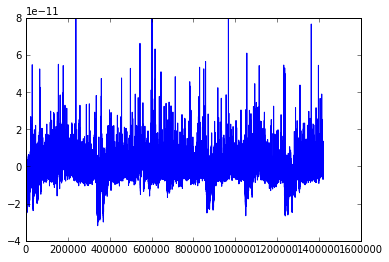

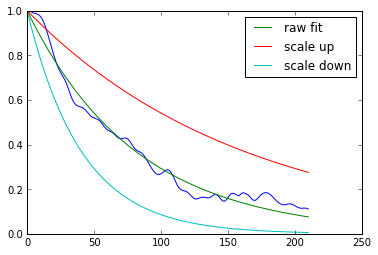

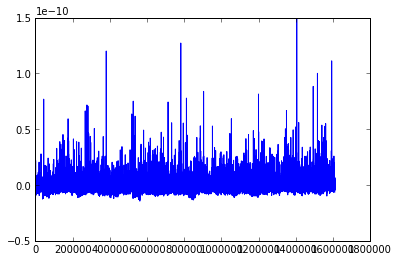

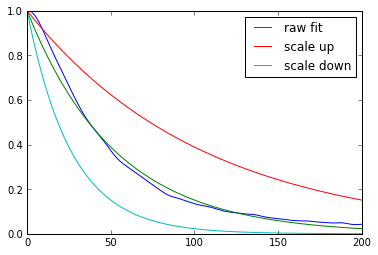

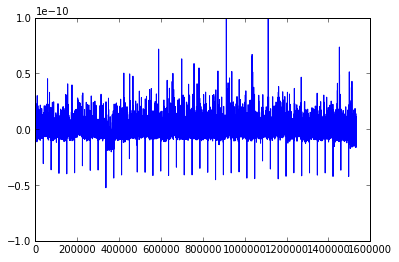

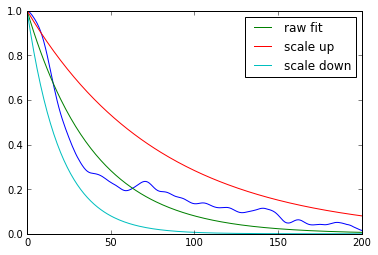

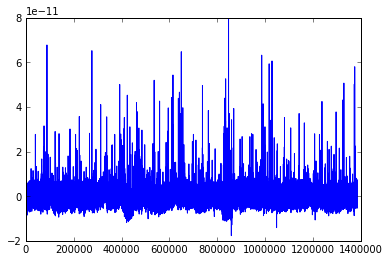

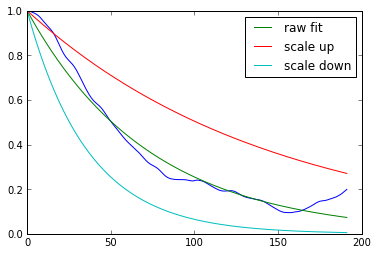

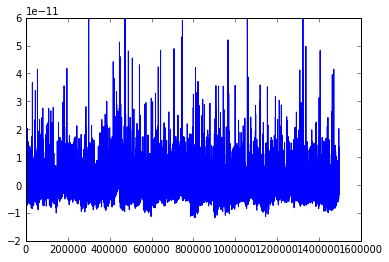

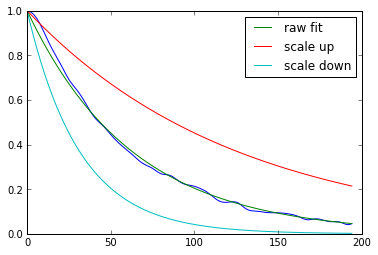

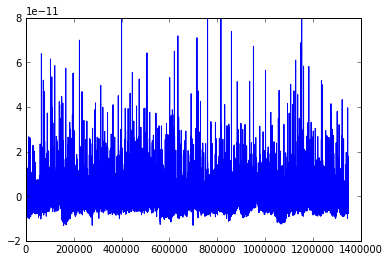

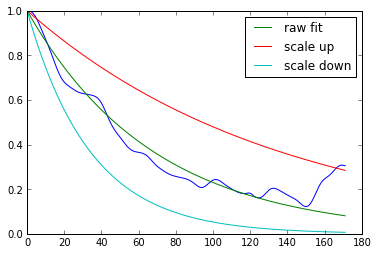

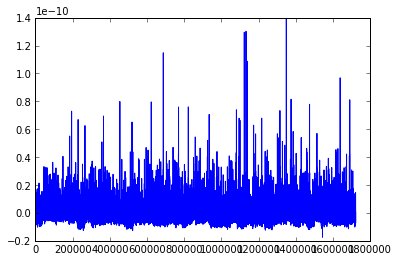

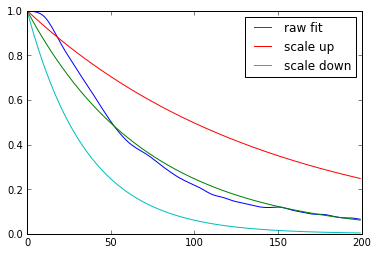

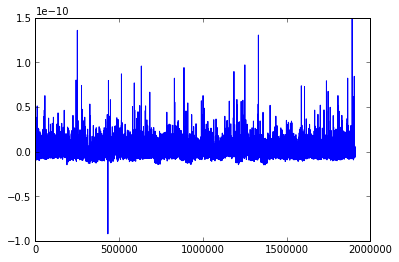

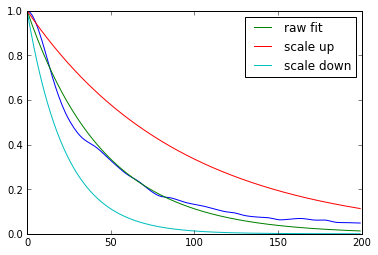

In [17]:
spon_list, psc_loc_track = spon_psc_ana(data_asso_2Hz_reci, 'psc_asso_2Hz_reci_slope2_thres2.5', bef_aft_choice='before', div_slope=2, thres=2.5)

/src/Patch_ana/Patch_ana/spon_ana.py:62: RuntimeWarning: overflow encountered in exp
  y = a * np.exp(-1 * t / tau1) + (1-a) * np.exp(-1 * t / tau2)
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


saving psc data from 139 ...


/src/Patch_ana/Patch_ana/spon_ana.py:62: RuntimeWarning: overflow encountered in multiply
  y = a * np.exp(-1 * t / tau1) + (1-a) * np.exp(-1 * t / tau2)


saving psc data from 140 ...


/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


saving psc data from 141 ...
saving psc data from 142 ...
saving psc data from 143 ...
saving psc data from 144 ...
saving psc data from 145 ...


/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


saving psc data from 146 ...


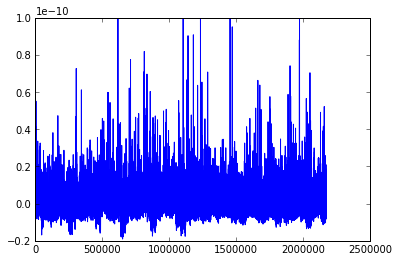

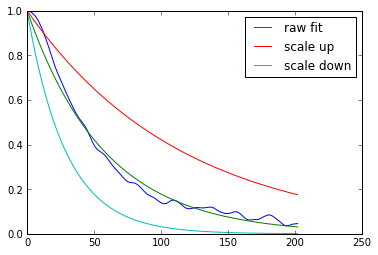

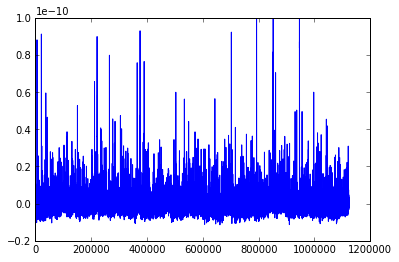

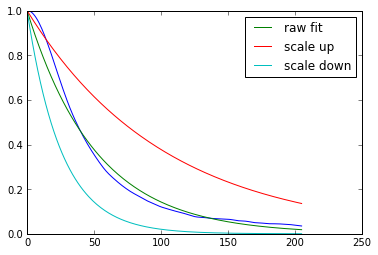

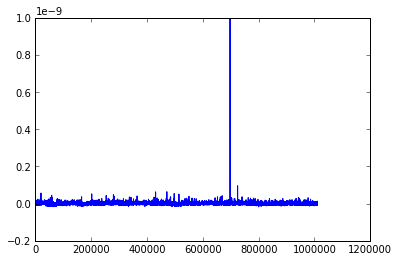

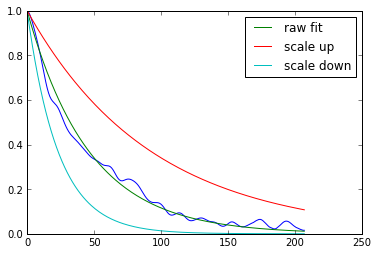

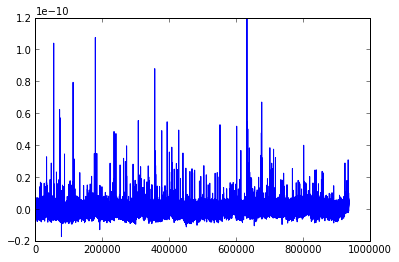

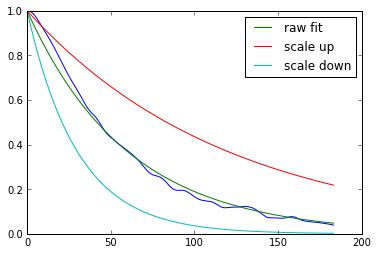

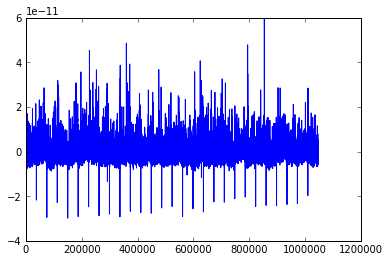

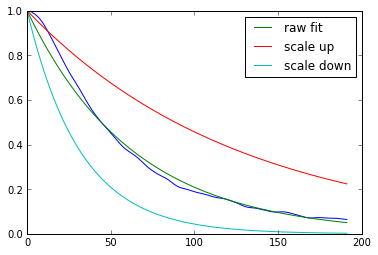

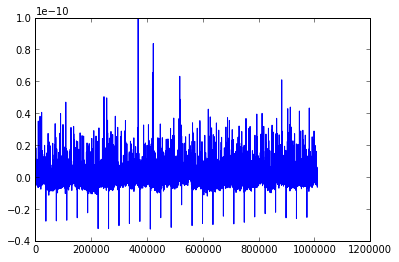

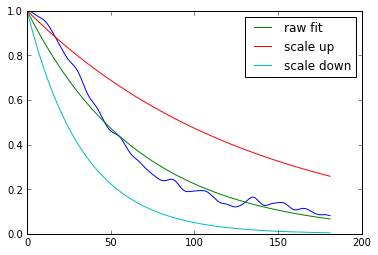

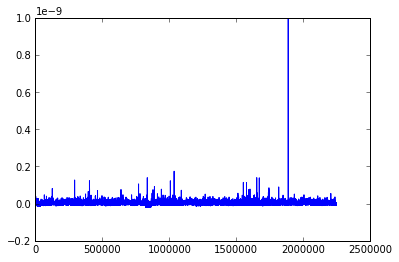

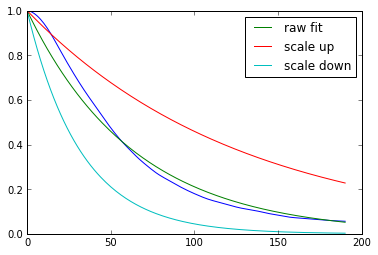

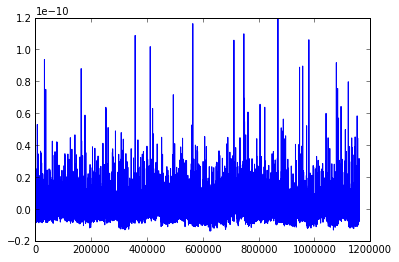

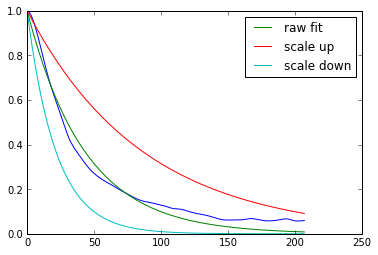

In [5]:
spon_list, psc_loc_track = spon_psc_ana(data_asso_2Hz_reci, 'psc_asso_2Hz_reci_slope2_thres2.5', bef_aft_choice='after', div_slope=2, thres=2.5)

In [9]:
spon_list, psc_loc_track = spon_psc_ana(data_anti, 'psc_post_2Hz_am_slope2_thres2.5', bef_aft_choice='before', div_slope=2, thres=2.5)

NameError: name 'data_anti' is not defined

In [ ]:
spon_list, psc_loc_track = spon_psc_ana(data_anti, 'psc_post_2Hz_am_slope2_thres2.5', bef_aft_choice='after', div_slope=2, thres=2.5)

In [ ]:
trace_id = 1
plt.plot(spon_list[trace_id])
plt.plot(psc_loc_track[trace_id], np.zeros(len(psc_loc_track[trace_id])), 'r*')

In [ ]:
# spon_psc_ana(data, 'psc_non_asso_AM251', bef_aft_choice='before')

In [ ]:
spon_psc_ana(data, 'psc_non_asso_50Hz_slope4_thres2.5', bef_aft_choice='after', div_slope=2, thres=2.5)